In [1]:
data_path = "data" 
seed = 46

**Imports and random seeding**

In [2]:
#!pip install transformers

In [3]:
#from transformers import BertTokenizer
#BertTokenizer?

In [4]:
import numpy as np
np.random.seed(seed)
np.random.RandomState(seed)

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.use_deterministic_algorithms(False)
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AutoTokenizer, AutoConfig

import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, confusion_matrix, balanced_accuracy_score

import itertools
from collections import Counter
import matplotlib.pyplot as plt

import seaborn as sns

import time

**Tokenization and label expansion**

In [5]:
df_train = pd.read_json(f"{data_path}/train.json")

# those entries contain invalid tokens, like Romani is tokenized as 'r', 'omani'
invalid_tokenization = [27, 1109, 1893, 2545, 3853, 3906, 6043, 6281, 7107, 7458, 8016, 8633, 8683, 8747, 8986, 10062, 10271, 11123, 12042, 12047, 12066]
df_train = df_train.drop(df_train.index[invalid_tokenization]).reset_index()

df_train.head()

,index,ner_tags,ner_ids,tokens,space_after
0,0,"[O, GPE, O, O, O, O, O, O, LOC, O, O, O, O, O,...","[0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...","[În, România, ,, ca, de, altfel, în, întreaga,...","[True, False, True, True, True, True, True, Tr..."
1,1,"[O, O, O, DATETIME, DATETIME, O, O, O, O, O, O...","[0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 13, 13, 1...","[Se, estimează, că, în, prezent, acestea, sunt...","[True, True, True, True, True, True, True, Tru..."
2,2,"[O, O, O, O, O, NUMERIC, O, O, O, PERSON, O, P...","[0, 0, 0, 0, 0, 13, 0, 0, 0, 1, 0, 1, 0, 0, 1,...","[Cartea, cuprinde, o, suită, de, 115, texte-re...","[True, True, True, True, True, True, True, Tru..."
3,3,"[O, O, O, O, O, O, O, O, O, O, O, DATETIME, DA...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0]","[Bursele, pentru, proiecte, ArtsLink, -, terme...","[True, True, True, True, True, True, True, Tru..."
4,4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Aplicația, informațională, este, însoțită, de...","[True, True, True, True, True, True, True, Tru..."


In [6]:
df_evaluation = pd.read_json(f"{data_path}/test.json")
df_evaluation.head()

,tokens,space_after
0,"[Cazul, tinerei, agresate, de, agenții, de, pa...","[True, True, True, True, True, True, True, Fal..."
1,"[\n, Scandal, la, Carrefour, Braşov, :, Unde, ...","[False, True, True, True, False, True, True, T..."
2,"[De, ce, câștigă, Facebook, și, când, utilizat...","[True, True, True, True, True, True, True, Tru..."
3,"[EXCLUSIV, !, Tupeu, fără, margini, !, Profi, ...","[False, True, True, True, False, True, True, T..."
4,"[PROFI, ,, în, mijlocul, unui, scandal, !, Rep...","[False, True, True, True, True, False, True, T..."


In [7]:
df_evaluation["tokens"].map(len).max() # max 99 tokens, so ~ 100 input size for BERT should be ok

99

In [8]:
def has_invalid_chars(sentences):
    bad_chars = set(["ţ", "ş", "Ş", "Ţ"])
    for sentence in sentences:
        for token in sentence:
            for letter in token:
                if letter in bad_chars:
                    return True
    return False

has_invalid_chars(df_train["tokens"]), has_invalid_chars(df_evaluation["tokens"])

(False, True)

In [9]:
bert_tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")

In [10]:
def sanitize_chars(text):
    return text.replace("ţ", "ț").replace("ş", "ș").replace("Ţ", "Ț").replace("Ş", "Ș")

def rejoin(tokens, space_after):
    l = []
    for t, s in zip(tokens, space_after):
        l.append(t)
        if s: l.append(' ')
    return sanitize_chars(''.join(l))

In [11]:
unique_labels = [set(l) for l in df_train["ner_ids"]]
labels_cnt = len(unique_labels[0].union(*unique_labels[1:]))
labels_cnt

16

In [12]:
EXTRA_LABEL = labels_cnt

def propagate_labels_to_bert(bert_tokens, premade_tokens, known_labels, dbg_idx=None):
    assert len(premade_tokens) == len(known_labels)
    
    labels = [EXTRA_LABEL for _ in range(len(bert_tokens))]
    reconstruction_array = []
    
    try:
        bert_tokens_idx = 1
        premade_tokens_idx = 0

        while bert_tokens_idx < len(bert_tokens) and premade_tokens_idx < len(premade_tokens):
            our_tk = premade_tokens[premade_tokens_idx]
            total_eaten = 0

            how_many_expanded = 0

            while total_eaten < len(our_tk):
                their_tk = bert_tokens[bert_tokens_idx]
                their_tk_strip = their_tk.replace("##", "")
                labels[bert_tokens_idx] = known_labels[premade_tokens_idx]

                # print(bert_tokens_idx, their_tk, our_tk, known_labels[premade_tokens_idx], "k =", total_eaten)

                total_eaten += len(their_tk_strip)
                bert_tokens_idx += 1

                how_many_expanded += 1

            reconstruction_array.append(how_many_expanded)

            premade_tokens_idx += 1
    except Exception as e:
        print("Invalid tokenization at", dbg_idx, str(e))
        
        # Broken entry, just set 0 everywhere. TODO: fix this later.
        labels = [0 for _ in range(len(premade_tokens))]
        reconstruction_array = [1 for _ in range(len(premade_tokens))]

    return labels, reconstruction_array

def reconstruct_labels_from_bert(bert_labels, reconstruction_array):
    labels = []
    bert_idx = 1
    
    for v in reconstruction_array:
        if v == 0 or bert_idx >= len(bert_labels):
            break
            
        #assert len(set(bert_labels[bert_idx:bert_idx+v])) == 1
        #print(set(bert_labels[bert_idx:bert_idx+v]))
        
        labels.append(bert_labels[bert_idx])
        bert_idx += v
        
    return labels

In [13]:
first_sentence = rejoin(df_train["tokens"][0], df_train["space_after"][0])
first_sentence_encoding = bert_tokenizer([first_sentence])[0].tokens

bert_labels, reconstruction_array = propagate_labels_to_bert(first_sentence_encoding, df_train["tokens"][0], df_train["ner_ids"][0])
# adding some 0s at the end won't change anything
assert reconstruct_labels_from_bert(bert_labels + [0], reconstruction_array + [0, 0, 0]) == df_train["ner_ids"][0]

In [14]:
class PerfTimer:
    def __init__(self):
        self.start_t = 0
        
    def start(self):
        self.start_t = time.time_ns()
         
    def stop(self, msg = None):
        elapsed = time.time_ns() - self.start_t
        if msg is not None:
            print(f"{msg}: took {elapsed} ns.")
        else:
            print(f"Elapsed {elapsed} ns.")
        return elapsed

def perf_check_tokenize(sentences, labels, tokenizer):
    full_sentences = [rejoin(tokens, space_after) for tokens, space_after in sentences]
    
    timer = PerfTimer()
    
    timer.start()
    tokenized_a = tokenizer(full_sentences)
    for i in range(len(full_sentences)):
        propagate_labels_to_bert(tokenized_a[i].tokens, sentences[i][0], labels[i])
    time_a = timer.stop('Tokenize the whole dataset. (A)')
    
    timer.start()
    tokenized_b = []
    for sentence in full_sentences:
        tokenized_b.append(tokenizer(sentence))
    for i in range(len(full_sentences)):
        propagate_labels_to_bert(tokenized_b[i].tokens(), sentences[i][0], labels[i])
    time_b = timer.stop('Tokenize each sentence. (B)')
        
    timer.start()
    tokenized_c = []
    for tokens, space_after in sentences:
        to_add = []
        for token in tokens:
            to_add.append(tokenizer(token))
        tokenized_c.append(to_add)
    time_c = timer.stop('Tokenize each word. (C)')
    
    m = max(time_a, time_b, time_c)
    print(f"Ratio to max {time_a/m:.4f}/{time_b/m:.4f}/{time_c/m:.4f}")

In [15]:
perf_check_tokenize(list(zip(df_train["tokens"][:1000], df_train["space_after"][:1000])), df_train["ner_ids"][:1000], bert_tokenizer)

Tokenize the whole dataset. (A): took 89005400 ns.
Tokenize each sentence. (B): took 239512600 ns.
Tokenize each word. (C): took 2768025200 ns.
Ratio to max 0.0322/0.0865/1.0000


In [16]:
df_train["sentence"] = df_train.apply(lambda x: rejoin(x['tokens'], x['space_after']), axis=1)
df_train.head()

,index,ner_tags,ner_ids,tokens,space_after,sentence
0,0,"[O, GPE, O, O, O, O, O, O, LOC, O, O, O, O, O,...","[0, 3, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...","[În, România, ,, ca, de, altfel, în, întreaga,...","[True, False, True, True, True, True, True, Tr...","În România, ca de altfel în întreaga Europă, s..."
1,1,"[O, O, O, DATETIME, DATETIME, O, O, O, O, O, O...","[0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 13, 13, 1...","[Se, estimează, că, în, prezent, acestea, sunt...","[True, True, True, True, True, True, True, Tru...",Se estimează că în prezent acestea sunt utiliz...
2,2,"[O, O, O, O, O, NUMERIC, O, O, O, PERSON, O, P...","[0, 0, 0, 0, 0, 13, 0, 0, 0, 1, 0, 1, 0, 0, 1,...","[Cartea, cuprinde, o, suită, de, 115, texte-re...","[True, True, True, True, True, True, True, Tru...",Cartea cuprinde o suită de 115 texte-remember ...
3,3,"[O, O, O, O, O, O, O, O, O, O, O, DATETIME, DA...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 0]","[Bursele, pentru, proiecte, ArtsLink, -, terme...","[True, True, True, True, True, True, True, Tru...",Bursele pentru proiecte ArtsLink - termen limi...
4,4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[Aplicația, informațională, este, însoțită, de...","[True, True, True, True, True, True, True, Tru...",Aplicația informațională este însoțită de un s...


In [17]:
MAX_TOKENS = 240
BERT_IN_TOKENS = MAX_TOKENS + 16
BERT_PAD = '[PAD]'

def fixed_sz(l, sz, elem):
    if len(l) >= sz:
        return l[:sz] 
    
    return l + [elem for _ in range(sz - len(l))]

def bert_encode(tokenizer, tokens, space_after, labels=None, trim=MAX_TOKENS):
    sentences = [rejoin(x[:trim], y[:trim]) for x, y in zip(tokens, space_after)]
    
    bert_encodings = tokenizer(sentences)
    bert_labels = []
    bert_reconstruction = []
    
    if labels is not None:
        bert_labels_and_reconstruction = [propagate_labels_to_bert(bert_encodings[i].tokens, tokens[i][:trim], labels[i][:trim], dbg_idx=i) for i in range(len(sentences))]
        bert_labels = [x[0] for x in bert_labels_and_reconstruction]
        bert_reconstruction = [x[1] for x in bert_labels_and_reconstruction]
        
    return bert_encodings, bert_labels, bert_reconstruction
  
def bert_decode(bert_labels, reconstruction_arrays):
    return [reconstruct_labels_from_bert(labels_i, reconstruction_array_i) for labels_i, reconstruction_array_i in zip(bert_labels, reconstruction_arrays)]

assert fixed_sz([1, 2, 3], 4, 0) == [1, 2, 3, 0]
assert fixed_sz([1, 2, 3], 3, 0) == [1, 2, 3]
assert fixed_sz([1, 2, 3], 2, 0) == [1, 2]

**Convert dataset to tensors and prepare loaders and model**

In [18]:
class BERTDataset(Dataset):
    def __init__(self, encodings, all_labels, all_reconstructions):
        self.all_reconstructions = [torch.as_tensor(fixed_sz(all_reconstructions[i], BERT_IN_TOKENS, 0)) for i in range(len(all_labels))]
        self.all_tokens = [fixed_sz(encodings[i].tokens, BERT_IN_TOKENS, BERT_PAD) for i in range(len(all_labels))]
        self.all_ids = [torch.as_tensor(fixed_sz(encodings[i].ids, BERT_IN_TOKENS, 0)) for i in range(len(all_labels))]
        self.all_attention_mask = [torch.as_tensor(fixed_sz(encodings[i].attention_mask, BERT_IN_TOKENS, 0)) for i in range(len(all_labels))]
        self.all_labels = [torch.as_tensor(fixed_sz(labels, BERT_IN_TOKENS, EXTRA_LABEL)) for labels in all_labels]

    def __getitem__(self, index):
        return {
            'ids': self.all_ids[index],
            'attention_mask': self.all_attention_mask[index],
            'reconstruction': self.all_reconstructions[index],
            'tokens': self.all_tokens[index],
            'labels': self.all_labels[index],
        }
    
    def __len__(self):
        return len(self.all_labels)

In [19]:
timer = PerfTimer()
timer.start()
bert_encodings, bert_labels, bert_reconstruction = bert_encode(bert_tokenizer, df_train["tokens"], df_train["space_after"], df_train["ner_ids"])
timer.stop("BERT Tokenization")

Invalid tokenization at 11004 list index out of range
BERT Tokenization: took 1534058500 ns.


1534058500

In [20]:
# NOTE: For some reason len(bert_encodings) always returns 3 (some strange logic inside), 
# so pleause use len() on other objects if you want to get the number of rows
X = [(bert_encodings[i], bert_labels[i], bert_reconstruction[i]) for i in range(len(bert_labels))]
y = df_train["ner_ids"]

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=seed, shuffle=True)

In [22]:
timer = PerfTimer()
timer.start()
zero_labels = [np.zeros(len(df_evaluation["tokens"][i])) for i in range(len(df_evaluation))]
bert_encodings, bert_labels, bert_reconstruction = bert_encode(bert_tokenizer, df_evaluation["tokens"], df_evaluation["space_after"], zero_labels)
timer.stop("BERT Tokenization (evaluation set)")

X_evaluation = [(bert_encodings[i], bert_labels[i], bert_reconstruction[i]) for i in range(len(bert_labels))]
y_evaluation = zero_labels

Invalid tokenization at 146 list index out of range
Invalid tokenization at 150 list index out of range
Invalid tokenization at 151 list index out of range
Invalid tokenization at 157 list index out of range
Invalid tokenization at 160 list index out of range
Invalid tokenization at 164 list index out of range
Invalid tokenization at 165 list index out of range
Invalid tokenization at 168 list index out of range
Invalid tokenization at 169 list index out of range
Invalid tokenization at 172 list index out of range
Invalid tokenization at 176 list index out of range
Invalid tokenization at 179 list index out of range
Invalid tokenization at 182 list index out of range
Invalid tokenization at 194 list index out of range
Invalid tokenization at 196 list index out of range
Invalid tokenization at 197 list index out of range
Invalid tokenization at 595 list index out of range
Invalid tokenization at 630 list index out of range
Invalid tokenization at 720 list index out of range
Invalid toke

In [23]:
from operator import itemgetter

def make_dataset(X, y):
    bert_encodings = list(map(itemgetter(0), X))
    bert_labels = list(map(itemgetter(1), X))
    bert_reconstruction = list(map(itemgetter(2), X))
    return BERTDataset(bert_encodings, bert_labels, bert_reconstruction)

dataset_train = make_dataset(X_train, y_train)
dataset_validation = make_dataset(X_val, y_val)
dataset_test = make_dataset(X_test, y_test)

dataset_evaluation = make_dataset(X_evaluation, y_evaluation)

In [24]:
all_ner_ids = df_train["ner_ids"].explode().tolist()

import collections
counts = collections.OrderedDict(sorted(collections.Counter(all_ner_ids).items()))
counts_values = counts.values()
max_class = max(counts_values)

print([max_class / i for i in counts_values])

[1.0, 10.497039910176584, 20.243996062992125, 32.162470680218924, 74.40007234581299, 81.57009716438628, 114.10762829403606, 613.9671641791044, 57.80747611017426, 19.242118065300776, 112.11719814663395, 100.77364037236649, 153.14892032762472, 51.39405297351324, 133.688007799805, 121.30875847832498]


In [25]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

configuration = AutoConfig.from_pretrained('dumitrescustefan/bert-base-romanian-cased-v1')
configuration.classifier_dropout = 0.4
configuration.attention_probs_dropout_prob = 0.4
configuration.hidden_dropout_prob = 0.4

configuration.num_labels = labels_cnt + 1
        
model = BertForTokenClassification.from_pretrained(pretrained_model_name_or_path = 'dumitrescustefan/bert-base-romanian-cased-v1', config=configuration)

#model = BertForTokenClassification.from_pretrained('dumitrescustefan/bert-base-romanian-cased-v1', num_labels=labels_cnt + 1)
model.to(device)

Some weights of the model checkpoint at dumitrescustefan/bert-base-romanian-cased-v1 were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification we

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.4, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [26]:
active = ['classifier.weight', 'classifier.bias', ]
for name, param in model.named_parameters():
    if name in active:
        param.requires_grad = True
    else:
        param.requires_grad = True
        
# freeze first 6 layers of training parameters

for name, param in list(model.named_parameters())[:-66]: 
    print('I will be frozen: {}'.format(name)) 
    param.requires_grad = False

I will be frozen: bert.embeddings.word_embeddings.weight
I will be frozen: bert.embeddings.position_embeddings.weight
I will be frozen: bert.embeddings.token_type_embeddings.weight
I will be frozen: bert.embeddings.LayerNorm.weight
I will be frozen: bert.embeddings.LayerNorm.bias
I will be frozen: bert.encoder.layer.0.attention.self.query.weight
I will be frozen: bert.encoder.layer.0.attention.self.query.bias
I will be frozen: bert.encoder.layer.0.attention.self.key.weight
I will be frozen: bert.encoder.layer.0.attention.self.key.bias
I will be frozen: bert.encoder.layer.0.attention.self.value.weight
I will be frozen: bert.encoder.layer.0.attention.self.value.bias
I will be frozen: bert.encoder.layer.0.attention.output.dense.weight
I will be frozen: bert.encoder.layer.0.attention.output.dense.bias
I will be frozen: bert.encoder.layer.0.attention.output.LayerNorm.weight
I will be frozen: bert.encoder.layer.0.attention.output.LayerNorm.bias
I will be frozen: bert.encoder.layer.0.intermed

In [39]:
from tqdm import tqdm

# def report(y_true, y_predict):
#     acc = balanced_accuracy_score(y_true, y_predict)
#     recall = recall_score(y_true, y_predict, average='micro')
#     f1 = f1_score(y_true, y_predict, average='micro')
#     return acc, recall, f1

def report(y_true, y_predict):
    labels = set(y_true)
    y_predict = [-1 if y not in labels else y for y in y_predict] + [-1]
    y_true = list(y_true) + [-1]
    
    acc = balanced_accuracy_score(y_true, y_predict)
    recall = recall_score(y_true, y_predict, average='micro')
    f1 = f1_score(y_true, y_predict, average='micro')
    return acc, recall, f1

def get_loader_params(batch_size):
    return {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 0
    }

class ScoreTracker:
    def __init__(self):
        self.reset()

    def update(self, loss, y_true, y_pred):
        self.total_loss += loss
        
        acc, recall, f1 = report(y_true, y_pred)
        self.acc_total += acc
        self.recall_total += recall
        self.f1_total += f1
        
        self.batches += 1
        
    def reset(self):
        self.total_loss = 0.0
        self.acc_total = 0.0
        self.recall_total = 0.0
        self.f1_total = 0.0
        self.batches = 0
        
    def get(self):
        return (
            self.total_loss / self.batches,
            self.acc_total / self.batches,
            self.recall_total / self.batches,
            self.f1_total / self.batches,
        )
    
    def get_str(self):
        values = self.get()
        return f"Averages: Loss {values[0]:.3f} Accuracy: {values[1]:.3f} Recall: {values[2]:.3f} F1-Score: {values[3]:.3f}"
     
def compute_model_output(model, batch):
    # move batch to GPU
    bacth_ids            = batch['ids'].to(device, dtype = torch.long)
    batch_attention_mask = batch['attention_mask'].to(device, dtype = torch.long)
    batch_labels         = batch['labels'].to(device, dtype = torch.long)

    # loss and probabilities
    loss, logits = model(input_ids=bacth_ids, attention_mask=batch_attention_mask, labels=batch_labels).values()

    # get predictions (flat)
    flattened_labels = batch_labels.view(-1)
    active_logits = logits.view(-1, model.num_labels)
    flattened_predictions = torch.argmax(active_logits, dim=1)

    # exclude uninteresting labels
    active_accuracy = batch_labels.view(-1) != EXTRA_LABEL
    flattened_labels = torch.masked_select(flattened_labels, active_accuracy)
    flattened_predictions = torch.masked_select(flattened_predictions, active_accuracy)
    
    return loss, flattened_labels, flattened_predictions    

def compute_model_prediction(model, batch):    
    # move batch to GPU
    bacth_ids            = batch['ids'].to(device, dtype = torch.long)
    batch_attention_mask = batch['attention_mask'].to(device, dtype = torch.long)

    # probabilities
    output = model(input_ids=bacth_ids, attention_mask=batch_attention_mask)
    logits = output.logits
    
    #predictions
    predictions = torch.argmax(logits, dim=2)
    
    return predictions.cpu().numpy()
    
def train(model, dataset, validation_dataset, train_parameters, epochs, eval_every_n_epochs):
    loader_params = get_loader_params(train_parameters['BATCH_SIZE'])
    loader = DataLoader(dataset, **loader_params)
    optimizer = train_parameters['OPTIMIZER'](params=model.parameters(), lr=train_parameters['LEARNING_RATE'], weight_decay=train_parameters['WEIGHT_DECAY'])
    
    model.train()
    sc = ScoreTracker()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        sc.reset()
        
        for i, batch in tqdm(enumerate(loader)):
            # zero gradients
            optimizer.zero_grad()
            
            # model pre
            loss, flattened_labels, flattened_predictions = compute_model_output(model, batch)
            sc.update(loss.item(), flattened_labels.cpu().numpy(), flattened_predictions.cpu().numpy())
            
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=train_parameters['MAX_GRAD_NORM']
            )

            # backward propagation
            loss.backward()
            optimizer.step()
                    
        if (epoch + 1) % eval_every_n_epochs == 0:
            print(f"Train. {sc.get_str()}")
            val_loss, val_acc = evaluate(model, validation_dataset, train_parameters)
            model.train()
        
        train_losses.append(sc.get()[0])
        train_accuracies.append(sc.get()[1])
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
    
    return train_losses, val_losses, train_accuracies, val_accuracies
            
def evaluate(model, dataset, evaluate_parameters):
    loader_params = get_loader_params(evaluate_parameters['BATCH_SIZE'])
    loader = DataLoader(dataset, **loader_params)
    
    model.eval()
    sc = ScoreTracker()
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(loader)):
            loss, flattened_labels, flattened_predictions = compute_model_output(model, batch)
            sc.update(loss.item(), flattened_labels.cpu().numpy(), flattened_predictions.cpu().numpy())
        
    print(f"Evaluate. {sc.get_str()}")
    
    return sc.get()[0], sc.get()[1]
    
def predict(model, dataset, parameters):
    batch_size = parameters['BATCH_SIZE']
    loader_params = get_loader_params(batch_size)
    loader_params['shuffle'] = False
    loader = DataLoader(dataset, **loader_params)
    
    model.eval()
    
    predictions = []
    labels = []
    
    with torch.no_grad():
        for i, batch in tqdm(enumerate(loader)):
            batch_predictions = compute_model_prediction(model, batch)
            predictions.extend(batch_predictions)
            labels.extend(batch['labels'].cpu().numpy())
    
    return bert_decode(predictions, map(itemgetter("reconstruction"), dataset)), labels

def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='train_loss', color='red')
    plt.plot(val_losses, label='val_loss', color='blue')
    plt.legend()
    plt.savefig("output/fig1.jpg")
    plt.show()

def plot_acc(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='train_accuracy', color='red')
    plt.plot(val_accuracies, label='val_accuracy', color='blue')
    plt.legend()
    plt.savefig("output/fig2.jpg")
    plt.show()

In [28]:
from operator import itemgetter

parameters = {
    "BATCH_SIZE": 8,
    "LEARNING_RATE": 1e-05,
    "WEIGHT_DECAY": 1e-06,
    "MAX_GRAD_NORM": 1.0,
    "OPTIMIZER": torch.optim.AdamW,
}

train_losses, val_losses, train_accuracies, val_accuracies = train(model, dataset_train, dataset_validation, parameters, 20, 1)

1231it [03:34,  5.74it/s]


Train. Averages: Loss 1.432 Accuracy: 0.547 Recall: 0.347 F1-Score: 0.347


154it [00:16,  9.35it/s]


Evaluate. Averages: Loss 0.524 Accuracy: 0.835 Recall: 0.614 F1-Score: 0.614


1231it [03:37,  5.66it/s]


Train. Averages: Loss 0.669 Accuracy: 0.773 Recall: 0.635 F1-Score: 0.635


154it [00:16,  9.19it/s]


Evaluate. Averages: Loss 0.367 Accuracy: 0.884 Recall: 0.756 F1-Score: 0.756


1231it [03:40,  5.59it/s]


Train. Averages: Loss 0.561 Accuracy: 0.811 Recall: 0.700 F1-Score: 0.700


154it [00:16,  9.13it/s]


Evaluate. Averages: Loss 0.323 Accuracy: 0.897 Recall: 0.794 F1-Score: 0.794


1231it [03:43,  5.51it/s]


Train. Averages: Loss 0.511 Accuracy: 0.831 Recall: 0.728 F1-Score: 0.728


154it [00:17,  8.95it/s]


Evaluate. Averages: Loss 0.307 Accuracy: 0.907 Recall: 0.821 F1-Score: 0.821


1231it [03:45,  5.46it/s]


Train. Averages: Loss 0.477 Accuracy: 0.839 Recall: 0.748 F1-Score: 0.748


154it [00:16,  9.07it/s]


Evaluate. Averages: Loss 0.293 Accuracy: 0.914 Recall: 0.836 F1-Score: 0.836


1231it [03:41,  5.55it/s]


Train. Averages: Loss 0.453 Accuracy: 0.846 Recall: 0.758 F1-Score: 0.758


154it [00:16,  9.09it/s]


Evaluate. Averages: Loss 0.279 Accuracy: 0.915 Recall: 0.845 F1-Score: 0.845


1231it [03:42,  5.54it/s]


Train. Averages: Loss 0.428 Accuracy: 0.853 Recall: 0.768 F1-Score: 0.768


154it [00:16,  9.07it/s]


Evaluate. Averages: Loss 0.272 Accuracy: 0.922 Recall: 0.856 F1-Score: 0.856


1231it [03:42,  5.54it/s]


Train. Averages: Loss 0.413 Accuracy: 0.861 Recall: 0.775 F1-Score: 0.775


154it [00:16,  9.07it/s]


Evaluate. Averages: Loss 0.258 Accuracy: 0.921 Recall: 0.850 F1-Score: 0.850


1231it [03:42,  5.53it/s]


Train. Averages: Loss 0.394 Accuracy: 0.867 Recall: 0.785 F1-Score: 0.785


154it [00:17,  9.04it/s]


Evaluate. Averages: Loss 0.257 Accuracy: 0.926 Recall: 0.862 F1-Score: 0.862


1231it [03:42,  5.53it/s]


Train. Averages: Loss 0.382 Accuracy: 0.870 Recall: 0.788 F1-Score: 0.788


154it [00:17,  9.04it/s]


Evaluate. Averages: Loss 0.249 Accuracy: 0.926 Recall: 0.867 F1-Score: 0.867


1231it [03:42,  5.53it/s]


Train. Averages: Loss 0.378 Accuracy: 0.872 Recall: 0.793 F1-Score: 0.793


154it [00:17,  9.05it/s]


Evaluate. Averages: Loss 0.255 Accuracy: 0.927 Recall: 0.871 F1-Score: 0.871


1231it [03:42,  5.53it/s]


Train. Averages: Loss 0.356 Accuracy: 0.877 Recall: 0.798 F1-Score: 0.798


154it [00:17,  8.97it/s]


Evaluate. Averages: Loss 0.247 Accuracy: 0.929 Recall: 0.874 F1-Score: 0.874


1231it [03:45,  5.46it/s]


Train. Averages: Loss 0.349 Accuracy: 0.880 Recall: 0.802 F1-Score: 0.802


154it [00:17,  9.05it/s]


Evaluate. Averages: Loss 0.247 Accuracy: 0.928 Recall: 0.869 F1-Score: 0.869


1231it [03:42,  5.53it/s]


Train. Averages: Loss 0.337 Accuracy: 0.883 Recall: 0.807 F1-Score: 0.807


154it [00:17,  9.04it/s]


Evaluate. Averages: Loss 0.240 Accuracy: 0.930 Recall: 0.878 F1-Score: 0.878


1231it [03:44,  5.49it/s]


Train. Averages: Loss 0.333 Accuracy: 0.884 Recall: 0.807 F1-Score: 0.807


154it [00:17,  8.88it/s]


Evaluate. Averages: Loss 0.233 Accuracy: 0.931 Recall: 0.883 F1-Score: 0.883


1231it [03:44,  5.48it/s]


Train. Averages: Loss 0.326 Accuracy: 0.887 Recall: 0.812 F1-Score: 0.812


154it [00:17,  9.05it/s]


Evaluate. Averages: Loss 0.244 Accuracy: 0.933 Recall: 0.884 F1-Score: 0.884


1231it [03:42,  5.52it/s]


Train. Averages: Loss 0.318 Accuracy: 0.889 Recall: 0.813 F1-Score: 0.813


154it [00:16,  9.06it/s]


Evaluate. Averages: Loss 0.234 Accuracy: 0.937 Recall: 0.887 F1-Score: 0.887


1231it [03:42,  5.52it/s]


Train. Averages: Loss 0.321 Accuracy: 0.887 Recall: 0.817 F1-Score: 0.817


154it [00:17,  9.05it/s]


Evaluate. Averages: Loss 0.241 Accuracy: 0.931 Recall: 0.888 F1-Score: 0.888


1231it [03:42,  5.52it/s]


Train. Averages: Loss 0.310 Accuracy: 0.889 Recall: 0.817 F1-Score: 0.817


154it [00:16,  9.07it/s]


Evaluate. Averages: Loss 0.240 Accuracy: 0.938 Recall: 0.889 F1-Score: 0.889


1231it [03:42,  5.52it/s]


Train. Averages: Loss 0.300 Accuracy: 0.893 Recall: 0.821 F1-Score: 0.821


154it [00:16,  9.07it/s]

Evaluate. Averages: Loss 0.236 Accuracy: 0.931 Recall: 0.889 F1-Score: 0.889


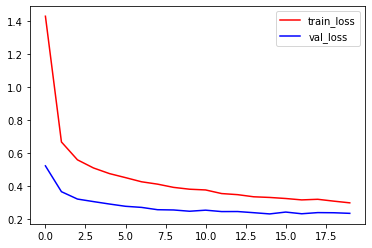

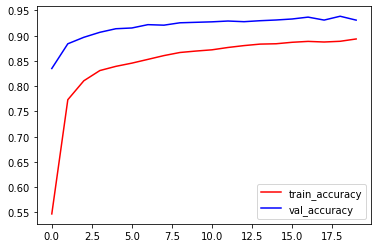

In [29]:
plot_loss(train_losses, val_losses)
plot_acc(train_accuracies, val_accuracies)

In [30]:
evaluate(model, dataset_validation, parameters)
evaluate(model, dataset_test, parameters)

154it [00:16,  9.06it/s]


Evaluate. Averages: Loss 0.236 Accuracy: 0.937 Recall: 0.890 F1-Score: 0.890


154it [00:16,  9.08it/s]

Evaluate. Averages: Loss 0.257 Accuracy: 0.930 Recall: 0.888 F1-Score: 0.888


(0.2570530753945569, 0.9300241350120962)

In [31]:
y_pred = predict(model, dataset_evaluation, parameters)

303it [00:32,  9.27it/s]


In [36]:
def plot_confustion_matrix(labels, predictions):
    fig, ax = plt.subplots(figsize=(8, 5))
    cmp = ConfusionMatrixDisplay(
        confusion_matrix(labels, predictions),
        display_labels=label_index.keys(),
    )

    cmp.plot(ax=ax)
    plt.show();

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
y_pred, labels = predict(model, dataset_train, parameters)

1231it [02:06,  9.70it/s]


In [41]:
flat_predictions = []
for i in range(len(df_evaluation)):
    # on some entries something went wrong :P TODO: fix it
    if len(y_pred[i]) < len(df_evaluation["tokens"][i]):
        y_pred[i] = fixed_sz(y_pred[i], len(df_evaluation["tokens"][i]), 0)
        
    flat_predictions.extend(y_pred[i])
    
print(len(flat_predictions))

116493


In [33]:
df_solution = pd.DataFrame({"ner_label": flat_predictions})
open("output/solution.csv", "w").write('Id' + df_solution.to_csv(index=True))

653270

In [34]:
import gc
gc.collect()

7557